
# 1️ Install dependencies


In [1]:

!pip install nltk rouge-score seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=007e230eb01692120c8b3e8d9612946cf44ec926789e9d24671873369c87ffc8
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score



# 2️ Imports


In [2]:

import json, re, random, math
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True


# 3️ Preprocessing


In [3]:

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9?.!,]+", " ", text)
    return text.strip()




# 4️ Load intents.json


In [4]:

def load_data(path):
    pairs = []
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    for intent in data["intents"]:
        for pattern in intent["patterns"]:
            response = random.choice(intent["responses"])
            pairs.append((normalize_text(pattern), normalize_text(response)))
    return pairs


# 5️ Vocabulary


In [5]:

PAD, SOS, EOS, UNK = "<pad>", "<sos>", "<eos>", "<unk>"

class Vocab:
    def __init__(self, min_freq=1):
        self.word2idx = {PAD:0, SOS:1, EOS:2, UNK:3}
        self.idx2word = {0:PAD, 1:SOS, 2:EOS, 3:UNK}
        self.min_freq = min_freq

    def build(self, texts):
        counter = Counter()
        for t in texts:
            counter.update(t.split())
        for word, freq in counter.items():
            if freq >= self.min_freq:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

    def encode(self, text):
        return [self.word2idx.get(w, self.word2idx[UNK]) for w in text.split()]

    def decode(self, ids):
        words = []
        for i in ids:
            if i == self.word2idx[EOS]:
                break
            words.append(self.idx2word.get(i, UNK))
        return " ".join(words)


# 6️ Dataset


In [6]:

class ChatDataset(Dataset):
    def __init__(self, pairs, vocab):
        self.pairs = pairs
        self.vocab = vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_ids = self.vocab.encode(src)
        tgt_ids = [self.vocab.word2idx[SOS]] + self.vocab.encode(tgt) + [self.vocab.word2idx[EOS]]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_lens = [len(s) for s in srcs]
    src_pad = nn.utils.rnn.pad_sequence(srcs, batch_first=True, padding_value=0)
    tgt_pad = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return src_pad, tgt_pad, src_lens


# 7️ Encoder (BiLSTM)


In [7]:


class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, bidirectional=True, batch_first=True)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        outputs, (h, c) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, h, c


# 8️ Attention


In [8]:


class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim*2, hid_dim)

    def forward(self, dec_hidden, enc_outputs):
        dec = dec_hidden.unsqueeze(1)
        energy = torch.tanh(self.attn(enc_outputs))
        scores = torch.sum(dec * energy, dim=2)
        return torch.softmax(scores, dim=1)


# 9️ Decoder


In [9]:


class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.attn = Attention(hid_dim)
        self.lstm = nn.LSTM(emb_dim + hid_dim*2, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim*3, vocab_size)

    def forward(self, token, hidden, cell, enc_outputs):
        emb = self.embedding(token.unsqueeze(1))
        attn_weights = self.attn(hidden[-1], enc_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs)
        lstm_input = torch.cat((emb, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)
        pred = self.fc(output)
        return pred, hidden, cell, attn_weights




# 10️ Seq2Seq


In [10]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lens, tgt, teacher_forcing=0.5):
        batch, tgt_len = tgt.shape
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch, tgt_len, vocab_size).to(self.device)

        enc_out, h, c = self.encoder(src, src_lens)
        hidden = h[0:1] + h[1:2]
        cell = c[0:1] + c[1:2]

        tok = tgt[:,0]

        for t in range(1, tgt_len):
            out, hidden, cell, _ = self.decoder(tok, hidden, cell, enc_out)
            outputs[:, t] = out
            tok = tgt[:, t] if random.random() < teacher_forcing else out.argmax(1)

        return outputs


# 11️ Training function


In [11]:

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for src, tgt, lens in loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(src, lens, tgt)
        loss = criterion(out[:,1:].reshape(-1, out.size(-1)), tgt[:,1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(loader)



# 12️ Chat functions


In [12]:

def chat(model, vocab, sentence, device, max_len=30):
    model.eval()
    src = torch.tensor([vocab.encode(normalize_text(sentence))]).to(device)
    lens = [src.size(1)]
    with torch.no_grad():
        enc_out, h, c = model.encoder(src, lens)
        hidden = h[0:1]+h[1:2]
        cell = c[0:1]+c[1:2]
        tok = torch.tensor([vocab.word2idx[SOS]]).to(device)
        result = []
        for _ in range(max_len):
            out, hidden, cell, _ = model.decoder(tok, hidden, cell, enc_out)
            tok = out.argmax(1)
            if tok.item()==vocab.word2idx[EOS]: break
            result.append(tok.item())
    return vocab.decode(result)

def beam_chat(model, vocab, sentence, device, beam_size=5, max_len=30):
    model.eval()
    src = torch.tensor([vocab.encode(normalize_text(sentence))]).to(device)
    lens = [src.size(1)]
    with torch.no_grad():
        enc_out, h, c = model.encoder(src, lens)
        hidden = h[0:1]+h[1:2]
        cell = c[0:1]+c[1:2]
        beams = [([vocab.word2idx[SOS]], 0.0, hidden, cell)]
        for _ in range(max_len):
            new_beams = []
            for seq, score, h, c in beams:
                tok = torch.tensor([seq[-1]]).to(device)
                out, h_new, c_new, _ = model.decoder(tok, h, c, enc_out)
                log_probs = torch.log_softmax(out, dim=1)
                topk = torch.topk(log_probs, beam_size)
                for i in range(beam_size):
                    idx = topk.indices[0][i].item()
                    val = topk.values[0][i].item()
                    new_beams.append((seq+[idx], score+val, h_new, c_new))
            beams = sorted(new_beams, key=lambda x:x[1], reverse=True)[:beam_size]
        return vocab.decode(beams[0][0][1:])


# 13️ Attention heatmap


In [13]:


# =
def visualize_attention(model, vocab, sentence, device):
    model.eval()
    sentence = normalize_text(sentence)
    src_tokens = vocab.encode(sentence)
    src = torch.tensor([src_tokens]).to(device)
    lens = [len(src_tokens)]
    attentions, outputs = [], []
    with torch.no_grad():
        enc_out, h, c = model.encoder(src, lens)
        hidden = h[0:1]+h[1:2]
        cell = c[0:1]+c[1:2]
        tok = torch.tensor([vocab.word2idx[SOS]]).to(device)
        for _ in range(20):
            out, hidden, cell, attn = model.decoder(tok, hidden, cell, enc_out)
            tok = out.argmax(1)
            if tok.item()==vocab.word2idx[EOS]: break
            attentions.append(attn.squeeze(0).cpu().numpy())
            outputs.append(vocab.idx2word[tok.item()])
    plt.figure(figsize=(10,5))
    sns.heatmap(attentions, xticklabels=sentence.split(), yticklabels=outputs, cmap="Blues")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.title("Attention Heatmap")
    plt.show()


# 14️ BLEU & ROUGE evaluation


In [14]:


def final_evaluation(model, dataset, vocab, device, n=200):
    smoothie = SmoothingFunction().method4
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    bleu, rouge = [], []
    for i in random.sample(range(len(dataset)), n):
        src, tgt = dataset[i]
        ref = vocab.decode(tgt.tolist()[1:-1])
        pred = beam_chat(model, vocab, vocab.decode(src.tolist()), device)
        bleu.append(sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie))
        rouge.append(scorer.score(ref, pred)["rougeL"].fmeasure)
    print("📊 FINAL EVALUATION")
    print("Average BLEU   :", round(sum(bleu)/len(bleu),4))
    print("Average ROUGE-L:", round(sum(rouge)/len(rouge),4))


# 15️ Loss & metric curves


In [15]:



def plot_curves(train_losses, bleu_scores, rouge_scores):
    plt.figure(figsize=(7,4))
    plt.plot(train_losses, marker="o")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(bleu_scores, label="BLEU", marker="o")
    plt.plot(rouge_scores, label="ROUGE-L", marker="o")
    plt.title("BLEU & ROUGE-L")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()


# 16️ Main: prepare data, model, train


In [16]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs = load_data("/content/intents.json")
texts = [x for p in pairs for x in p]

vocab = Vocab(min_freq=1)
vocab.build(texts)

dataset = ChatDataset(pairs, vocab)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

encoder = Encoder(len(vocab.word2idx), 128, 256)
decoder = Decoder(len(vocab.word2idx), 128, 256)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# metrics
train_losses, bleu_scores, rouge_scores = [], [], []

EPOCHS = 80
for epoch in range(EPOCHS):
    loss = train_epoch(model, loader, optimizer, criterion, device)
    train_losses.append(loss)

    # quick eval per epoch
    smoothie = SmoothingFunction().method4
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    bleu_epoch, rouge_epoch = [], []
    for i in random.sample(range(len(dataset)), 50):
        src, tgt = dataset[i]
        ref = vocab.decode(tgt.tolist()[1:-1])
        pred = chat(model, vocab, vocab.decode(src.tolist()), device)
        bleu_epoch.append(sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie))
        rouge_epoch.append(scorer.score(ref, pred)["rougeL"].fmeasure)

    bleu_scores.append(sum(bleu_epoch)/len(bleu_epoch))
    rouge_scores.append(sum(rouge_epoch)/len(rouge_epoch))
    print(f"Epoch {epoch+1}: loss={loss:.4f} BLEU={bleu_scores[-1]:.4f} ROUGE-L={rouge_scores[-1]:.4f}")

Epoch 1: loss=7.4051 BLEU=0.0070 ROUGE-L=0.0843
Epoch 2: loss=6.7775 BLEU=0.0121 ROUGE-L=0.1085
Epoch 3: loss=6.3009 BLEU=0.0121 ROUGE-L=0.1379
Epoch 4: loss=5.7122 BLEU=0.0156 ROUGE-L=0.1656
Epoch 5: loss=5.1374 BLEU=0.0259 ROUGE-L=0.2171
Epoch 6: loss=4.6588 BLEU=0.0251 ROUGE-L=0.2500
Epoch 7: loss=4.3028 BLEU=0.0463 ROUGE-L=0.2797
Epoch 8: loss=3.9930 BLEU=0.0684 ROUGE-L=0.3056
Epoch 9: loss=3.7502 BLEU=0.0807 ROUGE-L=0.3360
Epoch 10: loss=3.5285 BLEU=0.1053 ROUGE-L=0.3774
Epoch 11: loss=3.2945 BLEU=0.1525 ROUGE-L=0.4347
Epoch 12: loss=3.1050 BLEU=0.1761 ROUGE-L=0.4690
Epoch 13: loss=2.9596 BLEU=0.1596 ROUGE-L=0.4588
Epoch 14: loss=2.7398 BLEU=0.1809 ROUGE-L=0.4503
Epoch 15: loss=2.6343 BLEU=0.2278 ROUGE-L=0.4999
Epoch 16: loss=2.4691 BLEU=0.3437 ROUGE-L=0.5769
Epoch 17: loss=2.3415 BLEU=0.3370 ROUGE-L=0.5975
Epoch 18: loss=2.1643 BLEU=0.3489 ROUGE-L=0.5847
Epoch 19: loss=2.0338 BLEU=0.4564 ROUGE-L=0.6546
Epoch 20: loss=1.9083 BLEU=0.3636 ROUGE-L=0.5846
Epoch 21: loss=1.7540 BLEU=0.


# 17️ Curves


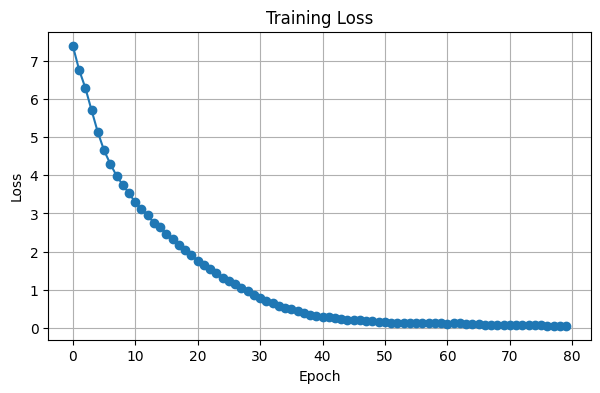

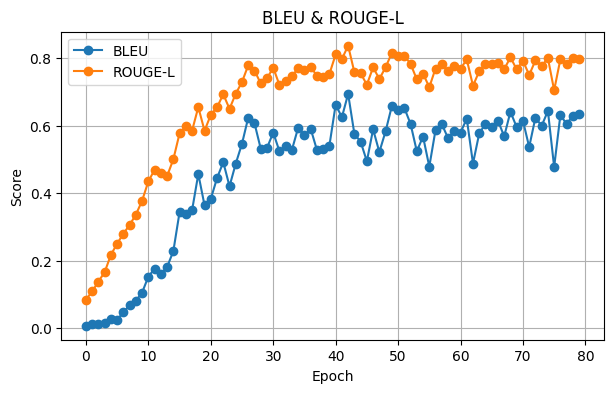

In [17]:



plot_curves(train_losses, bleu_scores, rouge_scores)


# 18️ Final evaluation


In [18]:



final_evaluation(model, dataset, vocab, device)

📊 FINAL EVALUATION
Average BLEU   : 0.6208
Average ROUGE-L: 0.7941



# 19️ Attention heatmap example


In [ ]:



visualize_attention(model, vocab, "what is dbms?", device)



# 20️ Interactive chatbot


In [ ]:

print("💬 Chatbot ready (type 'exit' to stop)")
while True:
    q = input("You: ")
    if q.lower()=="exit":
        print("Bot: bye 👋")
        break
    print("Bot:", beam_chat(model, vocab, q, device))


💬 Chatbot ready (type 'exit' to stop)
You: Explain machine learning
Bot: machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed. the fundamentals include understanding different types of learning supervised,
